# FPGA 硬件加速演示：FFT 与 FIR 滤波

本 Notebook 旨在演示基于 PYNQ-Z2 开发板的 FPGA 硬件加速性能，特别是针对数字信号处理（DSP）中常见的 **FFT（快速傅里叶变换）** 和 **FIR（有限脉冲响应）滤波** 算法。

在嵌入式系统和边缘计算中，将计算密集型任务从 CPU 卸载到 FPGA 逻辑上是提高实时性和能效的常见手段。本实验将对比 **纯软件实现 (CPU, ARM Cortex-A9)** 与 **硬件加速实现 (FPGA PL)** 在以下两个任务上的效率：

1.  **FFT (快速傅里叶变换)**：信号频域分析的核心算法。
2.  **FIR 滤波 + FFT 完整链路**：模拟真实的信号处理流水线，即信号先经过滤波去噪/提取，再进行频域分析。

我们将通过 Python (PYNQ 框架) 驱动硬件 Overlay，并使用 `time` 模块精确测量执行时间，计算加速比。

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay, allocate
from scipy import signal
import signal_generator as sg

# --- Configuration ---
FFT_LEN = 4096
FS = 4096

# --- Load Overlay ---
BITSTREAM_PATH = "design_1_wrapper.bit" # Fallback

print(f"Loading Overlay: {BITSTREAM_PATH}")
overlay = Overlay(BITSTREAM_PATH)

# Initialize DMAs
dma_data = overlay.axi_dma_0 # Data Path
dma_coef = overlay.axi_dma_1 # Coefficient Reload Path

print("Overlay loaded and DMAs initialized.")

# --- Helper Functions ---

def reload_fir_coefficients(coeffs):
    """Reloads FIR filter coefficients using DMA."""
    coeffs_int16 = np.array(coeffs, dtype=np.int16)
    buffer_size = len(coeffs_int16)
    coef_buffer = allocate(shape=(buffer_size,), dtype=np.int32)
    np.copyto(coef_buffer, coeffs_int16)
    dma_coef.sendchannel.transfer(coef_buffer)
    dma_coef.sendchannel.wait()
    del coef_buffer

def run_hardware_chain(signal_data):
    """Executes Hardware FIR -> FFT chain."""
    in_buffer = allocate(shape=(FFT_LEN,), dtype=np.int32)
    # Ensure signal is within int16 range
    sig_int16 = np.int16(signal_data)
    np.copyto(in_buffer, sig_int16)
    
    out_buffer = allocate(shape=(FFT_LEN,), dtype=np.float32)
    
    start_time = time.perf_counter()
    dma_data.recvchannel.transfer(out_buffer)
    dma_data.sendchannel.transfer(in_buffer)
    dma_data.sendchannel.wait()
    dma_data.recvchannel.wait()
    end_time = time.perf_counter()
    
    result = np.copy(out_buffer)
    del in_buffer
    del out_buffer
    
    exec_time_ms = (end_time - start_time) * 1000
    return result, exec_time_ms

def software_fft(signal_data):
    """Executes Software FFT."""
    start_time = time.perf_counter()
    result = np.abs(np.fft.fft(signal_data))
    end_time = time.perf_counter()
    exec_time_ms = (end_time - start_time) * 1000
    return result, exec_time_ms

def get_fir_coeffs(filter_type, cutoff_hz, num_taps=21, gain=100):
    """Generates FIR coefficients."""
    nyq = 0.5 * FS
    norm_cutoff = cutoff_hz / nyq
    norm_cutoff = np.clip(norm_cutoff, 0.01, 0.99)
    
    if filter_type == "Pass-Through":
        coeffs = np.zeros(num_taps)
        coeffs[10] = 0.2
    elif filter_type == "Low-Pass":
        coeffs = signal.firwin(num_taps, norm_cutoff)
    elif filter_type == "High-Pass":
        coeffs = signal.firwin(num_taps, norm_cutoff, pass_zero=False)
    elif filter_type == "Band-Pass":
        width = 0.1
        low = max(0.01, norm_cutoff - width)
        high = min(0.99, norm_cutoff + width)
        coeffs = signal.firwin(num_taps, [low, high], pass_zero=False)
    else:
        coeffs = np.zeros(num_taps)
        coeffs[num_taps // 2] = 1.0

    return np.int16(coeffs * gain)

# Global storage for benchmark results
benchmark_results = {}

Loading Overlay: design_2_wrapper.bit
Overlay loaded and DMAs initialized.


In [ ]:
# --- Generate 6 Simulated Signals ---
t = np.arange(FFT_LEN) / FS
signals = {}

# 1. White Noise
signals["Noise"] = sg.generate_white_noise(FFT_LEN)

# 2. Sine Wave (50Hz)
signals["Sine_50Hz"] = sg.generate_sine_wave(t, freq=50, amplitude=500)

# 3. Multi-Sine (50Hz + 200Hz + 1000Hz)
signals["Multi_Sine"] = sg.generate_multi_sine_wave(t, freqs=[50, 200, 1000], amplitudes=[0.5, 0.3, 0.2], base_amplitude=500)

# 4. Square Wave (50Hz)
signals["Square_50Hz"] = sg.generate_square_wave(t, freq=50, amplitude=500)

# 5. Chirp Signal (10Hz - 1000Hz)
signals["Chirp"] = sg.generate_chirp_signal(t, start_freq=10, end_freq=1000, amplitude=500)

# 6. AM Signal (Carrier 500Hz, Signal 20Hz)
signals["AM_Signal"] = sg.generate_am_signal(t, carrier_freq=500, signal_freq=20, amplitude=500)

print("Generated Signals:", list(signals.keys()))

# Set Pass-Through filter for pure FFT comparison initially
coeffs_pass = get_fir_coeffs("Pass-Through", 0)
reload_fir_coefficients(coeffs_pass)
print("FIR Filter set to Pass-Through mode.")

Generated Signals: ['Noise', 'Sine_50Hz', 'Multi_Sine', 'Square_50Hz', 'Chirp', 'AM_Signal']
FIR Filter set to Pass-Through mode.


### 1. 系统初始化与信号生成

在此步骤中，我们需要完成软硬件环境的准备工作：

*   **加载 Overlay (`design_2_wrapper.bit`)**：将预先综合好的硬件比特流下载到 FPGA PL 端。该硬件设计包含了一个 AXI DMA 模块用于数据搬运，以及级联的 FIR 滤波器和 FFT 硬件加速器 IP 核。
*   **初始化 DMA**：配置 AXI DMA 通道，建立 PS (Processing System, CPU) 与 PL (Programmable Logic, FPGA) 之间的高速数据通路。
*   **生成测试信号**：为了全面评估性能，我们利用 `signal_generator` 库生成了多种类型的模拟信号，包括白噪声、单频正弦波、多频正弦波、方波、Chirp 信号和调幅波。

**注意**：初始状态下，我们将 FIR 滤波器系数配置为 **直通模式 (Pass-Through)**（即不做滤波处理，输出等于输入），这样硬件链路就等效于仅执行 FFT。这使我们能够在第一阶段专注于对比 FFT 的硬件加速性能。

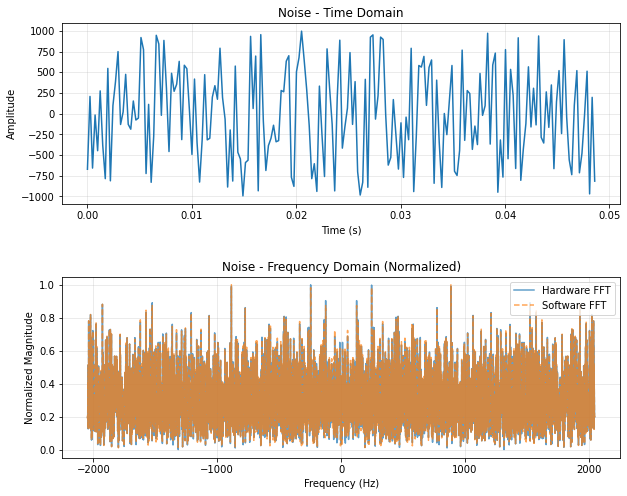

--- Noise Benchmark ---
Hardware Execution Time: 1.3996 ms
Software Execution Time: 2.5600 ms
Hardware Acceleration Speedup: 1.83x


In [ ]:
signal_name = "Noise"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

### 2. 纯 FFT 性能基准测试

在直通模式下，我们分别对不同类型的信号进行 FFT 变换，以对比软硬件性能。

*   **硬件流程**：
    1.  CPU 将时域信号写入连续内存缓冲区 (CMA)。
    2.  DMA 将数据搬运至 FPGA (FIR IP -> FFT IP)。
    3.  FPGA 流水线处理数据（FIR 直通，FFT 计算）。
    4.  DMA 将频域结果搬回内存。
    5.  CPU 读取结果。
    *耗时包含：数据搬运时间 + 硬件计算时间。*

*   **软件流程**：
    1.  直接调用 `numpy.fft.fft` 在 CPU 上计算。
    *耗时包含：纯 CPU 计算时间。*

我们将逐一运行测试，并绘制时域波形和频域频谱图，以验证硬件计算结果的正确性（与软件结果对比是否一致）。

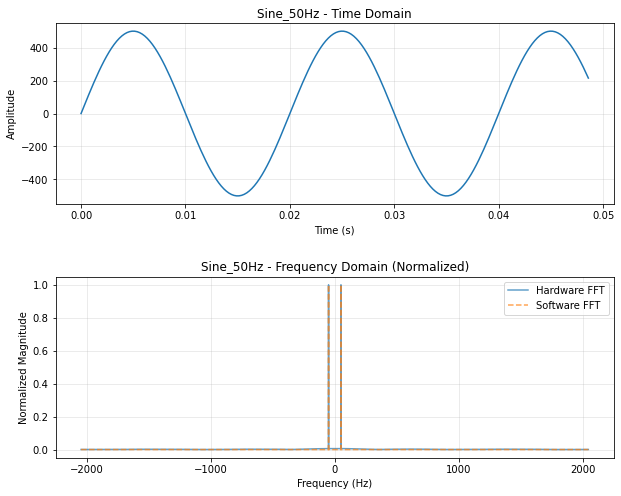

--- Sine_50Hz Benchmark ---
Hardware Execution Time: 1.4604 ms
Software Execution Time: 2.7403 ms
Hardware Acceleration Speedup: 1.88x


In [ ]:
signal_name = "Sine_50Hz"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

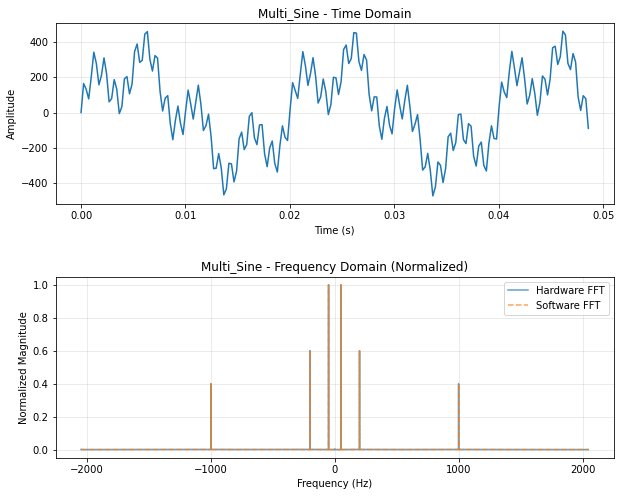

--- Multi_Sine Benchmark ---
Hardware Execution Time: 1.4498 ms
Software Execution Time: 2.5724 ms
Hardware Acceleration Speedup: 1.77x


In [ ]:
signal_name = "Multi_Sine"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

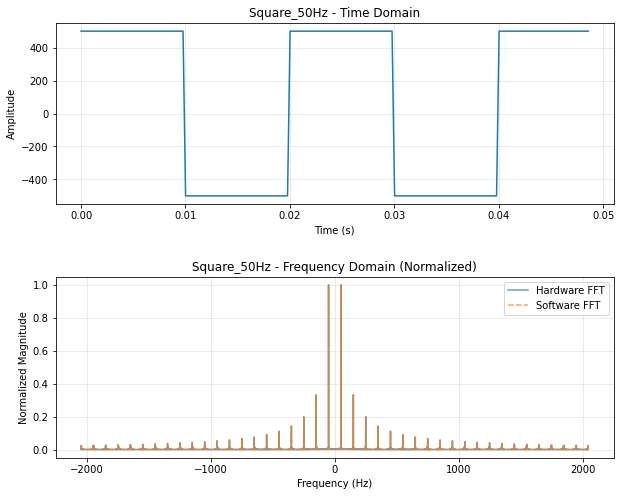

--- Square_50Hz Benchmark ---
Hardware Execution Time: 1.4777 ms
Software Execution Time: 2.5644 ms
Hardware Acceleration Speedup: 1.74x


In [ ]:
signal_name = "Square_50Hz"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

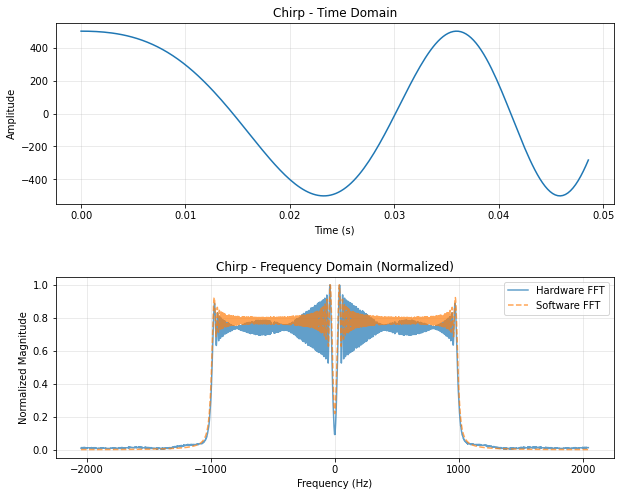

--- Chirp Benchmark ---
Hardware Execution Time: 1.3966 ms
Software Execution Time: 3.2243 ms
Hardware Acceleration Speedup: 2.31x


In [ ]:
signal_name = "Chirp"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

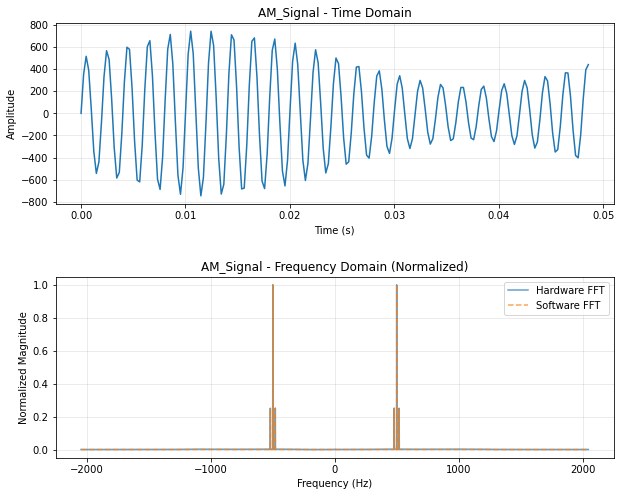

--- AM_Signal Benchmark ---
Hardware Execution Time: 1.4389 ms
Software Execution Time: 3.1793 ms
Hardware Acceleration Speedup: 2.21x


In [ ]:
signal_name = "AM_Signal"
sig = signals[signal_name]

# Execute
hw_res, hw_time = run_hardware_chain(sig)
sw_res, sw_time = software_fft(sig)

# Normalize
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)

# Store Result
benchmark_results[signal_name] = (hw_time, sw_time)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Time Domain
axs[0].plot(t[:200], sig[:200])
axs[0].set_title(f"{signal_name} - Time Domain")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)

# Frequency Domain
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware FFT", alpha=0.7)
axs[1].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software FFT", alpha=0.7, linestyle="--")
axs[1].set_title(f"{signal_name} - Frequency Domain (Normalized)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Magnitude")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()

# Output Info
speedup = sw_time / hw_time
print(f"--- {signal_name} Benchmark ---")
print(f"Hardware Execution Time: {hw_time:.4f} ms")
print(f"Software Execution Time: {sw_time:.4f} ms")
print(f"Hardware Acceleration Speedup: {speedup:.2f}x")

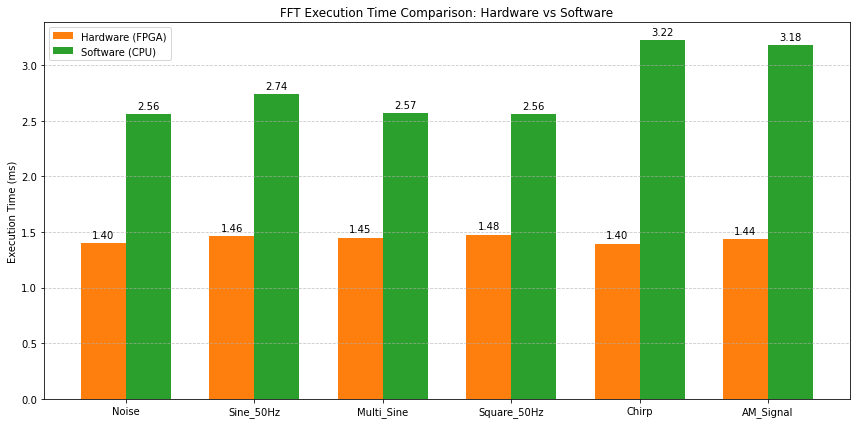

In [ ]:
# --- Performance Summary ---
names = list(benchmark_results.keys())
hw_times = [benchmark_results[n][0] for n in names]
sw_times = [benchmark_results[n][1] for n in names]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, hw_times, width, label='Hardware (FPGA)', color='#ff7f0e')
rects2 = ax.bar(x + width/2, sw_times, width, label='Software (CPU)', color='#2ca02c')

ax.set_ylabel('Execution Time (ms)')
ax.set_title('FFT Execution Time Comparison: Hardware vs Software')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()

### 3. FFT 性能测试总结

下方的柱状图汇总了上述所有信号的测试结果。

**结果分析思路**：
*   **加速比**：观察硬件执行时间是否显著低于软件执行时间。对于 4096 点的 FFT，FPGA 通常能提供显著的加速，因为 FFT 算法在硬件上可以高度并行化（蝶形运算）。
*   **数据传输开销**：PYNQ 框架涉及 Python 运行时的开销以及 DMA 数据搬运的开销。如果数据量过小，搬运开销可能会抵消硬件加速的收益。但在本实验的 4096 点规模下，通常能观察到正向收益。
*   **稳定性**：硬件执行时间通常非常稳定（确定性延迟），而软件执行时间可能会受操作系统调度影响产生波动。

In [ ]:
def software_fir_fft(signal_data, coeffs_int16, gain=100):
    """
    Executes Software FIR -> FFT chain for comparison.
    Simulates the hardware chain in software using scipy.signal.lfilter.
    """
    start_time = time.perf_counter()
    
    # Convert int16 coeffs back to float for Scipy
    coeffs_float = coeffs_int16.astype(np.float32) / gain
    
    # Software FIR Filtering 
    # b = coeffs, a = 1.0 (FIR)
    filtered_signal = signal.lfilter(coeffs_float, 1.0, signal_data)
    
    # Software FFT
    result = np.abs(np.fft.fft(filtered_signal))
    
    end_time = time.perf_counter()
    exec_time_ms = (end_time - start_time) * 1000
    return result, exec_time_ms

print("Software Full Chain (FIR + FFT) function defined.")

### 4. 完整链路对比：FIR 滤波 + FFT

在实际应用中，FFT 往往不是单独使用的，通常需要先对信号进行预处理（如低通滤波去除高频噪声）。为了更全面地评估硬件加速在**系统级**任务中的效果，我们引入 FIR 滤波环节。

*   **硬件优势**：在 FPGA 设计中，FIR 滤波器和 FFT 模块通过 AXI-Stream 接口直接级联。数据在硬件内部流水线流动，**无需**中间回到 CPU 内存。这意味着增加 FIR 滤波环节几乎**不会增加额外的数据搬运时间**，只会增加少量的流水线延迟。
*   **软件劣势**：在软件实现中，必须先执行滤波函数（如 `scipy.signal.lfilter`），计算完成后写入内存，再读取内存执行 FFT。这是串行的两步操作，总耗时是两者之和。

此处我们定义了一个 `software_fir_fft` 函数，用于模拟这个串行的软件处理流程，以便与硬件的“一次搬运，流水处理”进行公平对比。

In [ ]:
# --- Benchmark: Hardware Chain vs Software Full Chain ---

# Configuration
test_signal = signals["Multi_Sine"]
# Generate Low-Pass coefficients (using default 21 taps)
coeffs_lp = get_fir_coeffs("Low-Pass", cutoff_hz=100, num_taps=21, gain=100)

# 1. Run Hardware Chain (Reload Coeffs + Process)
reload_fir_coefficients(coeffs_lp)
# Warmup
run_hardware_chain(test_signal)
# Measure
hw_res, hw_time = run_hardware_chain(test_signal)

# 2. Run Software Chain
sw_res, sw_time = software_fir_fft(test_signal, coeffs_lp, gain=100)

# 3. Get Original Signal Spectrum for comparison
orig_fft = np.abs(np.fft.fft(test_signal))

# Normalize for plotting
hw_norm = hw_res / np.max(hw_res)
sw_norm = sw_res / np.max(sw_res)
orig_norm = orig_fft / np.max(orig_fft)

# --- Visualization ---
print(f"--- Efficiency Comparison (Signal: Multi_Sine, Filter: Low-Pass) ---")
print(f"Hardware (FIR + FFT): {hw_time:.4f} ms")
print(f"Software (FIR + FFT): {sw_time:.4f} ms")
print(f"Speedup Factor: {sw_time / hw_time:.2f}x")

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

# Plot 1: Frequency Domain Comparison
freqs = np.fft.fftfreq(FFT_LEN, 1/FS)
# Plot Original Signal
axs[0].plot(np.fft.fftshift(freqs), np.fft.fftshift(orig_norm), label="Original Signal (Unfiltered)", color='#d62728', alpha=0.5, linestyle='-', linewidth=1.5)
# Plot Processed Signals
axs[0].plot(np.fft.fftshift(freqs), np.fft.fftshift(hw_norm), label="Hardware Chain Output", alpha=0.8, linewidth=2)
axs[0].plot(np.fft.fftshift(freqs), np.fft.fftshift(sw_norm), label="Software Chain Output", alpha=0.8, linestyle="--", linewidth=2)

axs[0].set_title("Spectral Result Comparison (Low-Pass 100Hz)")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Normalized Magnitude")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Execution Time Comparison
methods = ['Hardware Chain\n(FIR + FFT)', 'Software Chain\n(FIR + FFT)']
times = [hw_time, sw_time]
colors = ['#ff7f0e', '#2ca02c']

bars = axs[1].bar(methods, times, color=colors, width=0.4)
axs[1].set_ylabel('Execution Time (ms)')
axs[1].set_title('Execution Time Comparison')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} ms',
             ha='center', va='bottom')

plt.show()

### 5. 最终实测：硬件 vs 软件 (滤波+FFT)

这是本实验的最终综合测试。我们使用 **多频正弦信号 (Multi-Sine)**（包含 50Hz, 200Hz, 1000Hz 分量）和 **低通滤波器 (Low-Pass, 截止频率 100Hz)** 进行测试。

**预期结果与分析**：
1.  **频谱图验证**：
    *   **红色曲线（原始信号）**：应能看到 50Hz, 200Hz, 1000Hz 三个明显的峰值。
    *   **蓝/橙曲线（处理后信号）**：200Hz 和 1000Hz 的高频分量应被显著抑制（幅度大幅下降），仅保留 50Hz 的低频分量。
    *   硬件与软件的输出曲线应高度重合，证明硬件计算精度符合要求。

2.  **效率对比**：
    *   由于硬件采用了流式级联设计，相比于之前的纯 FFT 测试，硬件耗时增加极少。
    *   而软件耗时会显著增加（因为增加了 FIR 滤波的计算量）。
    *   因此，**完整链路的加速比通常会比纯 FFT 测试更高**，充分体现了 FPGA 在复杂流水线任务中的巨大优势。